In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import sys
import csv
import os
from sklearn import metrics
from dateutil.parser import parse
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

In [2]:
data_version_input = "01-10-2020"

In [3]:
df_train = pd.read_csv(f"../../data/kalapa/{data_version_input}/train.csv")
df_test = pd.read_csv(f"../../data/kalapa/{data_version_input}/test.csv")

/home/parker/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (35) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/parker/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (34) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_transform = pd.concat([df_train.iloc[:,2:], df_test.iloc[:,1:]], axis = 0)

In [5]:
data_type = {
    "cat_num":["Field_22","Field_13", "Field_41", "Field_42","Field_50", "Field_51", "Field_53",\
               "Field_73",  "partner0_A", "partner0_B", "partner0_C", "partner0_D", "partner0_E",\
               "partner0_F", "partner0_G", "partner0_H", "partner1_A", "partner1_C", "partner1_G", "partner1_H",\
               "partner2_A", "partner2_C", "partner2_D", "partner2_F", "partner2_H","partner3_A", "partner3_D",\
               "partner3_E", "partner4_L", "partner5_A", "partner5_D", "partner5_G"],
    "cat_str" : ["Field_3","Field_4", "Field_12","Field_36", "Field_38", "Field_54", "Field_62","Field_65", \
                 "Field_66", "info_social_sex", "brief", "gioiTinh"], 
    "date" : ["Field_1", "Field_2", "Field_5", "Field_6", "Field_7", "Field_8", "Field_9", "Field_11",\
             "Field_15", "Field_25", "Field_32", "Field_33", "Field_35", "Field_40","Field_43", "Field_44", \
              "F_startDate", "F_endDate", "E_startDate", "E_endDate", "C_startDate",
             "C_endDate", "G_startDate", "G_endDate", "A_startDate", "A_endDate"],
    "text" : ["Field_18","currentLocationCity", "homeTownCity", "Field_48", "Field_49","currentLocationName",\
             "currentLocationCountry", "currentLocationState", 'homeTownState','data.basic_info.locale', "maCv",\
              'homeTownName', "homeTownCountry", "Field_61"],
    "drop" : ["Field_45", "Field_34","Field_68", "diaChi", "Field_46", "Field_55"]
}

In [6]:
for feature in data_type["text"]:
    vc = df_transform[feature].value_counts()
    print(f"{feature} : {len(vc)} : {vc.index[:7]}")

Field_18 : 8727 : Index(['.', 'KD', 'Sản xuất', 'thành phố Biên Hòa', 'Kinh doanh', ',', '1'], dtype='object')
currentLocationCity : 1020 : Index(['Ho Chi Minh City', 'Hanoi', 'Da Nang', 'Thanh Hóa', 'Hai Phong',
       'Thái Nguyên', 'Biên Hòa'],
      dtype='object')
homeTownCity : 1013 : Index(['Hanoi', 'Ho Chi Minh City', 'Thanh Hóa', 'Hai Phong', 'Bac Giang',
       'Thái Bình', 'Bac Ninh'],
      dtype='object')
Field_48 : 15760 : Index(['153 Xô Viết Nghệ Tĩnh Quận Bình Thạnh', 'Bình Dương',
       '162 Tô Hiệu, Hà Cầu, Hà Đông, Hà Nội',
       '128 Trần Quang Khải, P. Tân Định, Q.1',
       'Tầng 2 Tòa nhà REE Tower số 9 Đoàn Văn Bơ, P12, Q4, Tp.HCM',
       'KCN Yên Bình 1, phường Đồng Tiến, thị xã  Phổ Yên, tỉnh Thái Nguyên',
       'Tầng trệt Tòa Nhà Rosana, Số 60 Nguyễn Đình Chiểu, P. Đao Kao, Q.1, TP. HCM'],
      dtype='object')
Field_49 : 15975 : Index(['153 Xô Viết Nghệ Tĩnh Quận Bình Thạnh', 'Bình Dương',
       '162 Tô Hiệu, Hà Cầu, Hà Đông, Hà Nội',
       '(Buu dien)

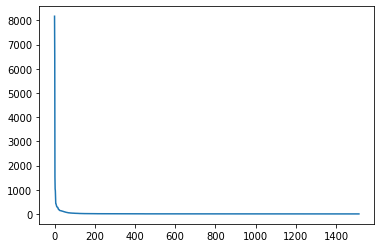

Doanh nghiệp có vốn đầu tư nước ngoài                                                           8175
Là những người thuộc hộ gia đình, trừ các đối tượng trên                                        6536
Người đang hưởng trợ cấp thất nghiệp                                                            1531
Ngoài quốc doanh Tỉnh/TP                                                                        1031
Ngoài quốc doanh Quận 1                                                                          957
Doanh nghiệp nhà nước TW                                                                         640
Hành chánh sự nghiệp Tỉnh/TP                                                                     430
Doanh nghiệp nhà nước Tỉnh/TP                                                                    423
Học sinh sinh viên                                                                               393
Hộ gia đình làm nông, lâm, ngư diêm nghiệp                                                 

In [7]:
data = list(df_transform["Field_56"].value_counts())
plt.plot(data)
plt.show()
df_transform["Field_56"].value_counts()[:50]

In [8]:
def create_other(indexes, x):
    if x in indexes:
        return x
    elif x is np.nan:
        return "NaN"
    return "other"

In [9]:
def findandreplace(df, feature):
    df[feature] = df[feature].fillna("Nan")
    classes = {}
    k = 0
    vc = df[feature].value_counts()
    uniques = vc.index
    for unique in uniques:
        classes[unique] = k
        k += 1
    df[feature] = df[feature].map(lambda x: classes[x])
    return df

In [10]:
def keep_num_value(df, feature, n):
    indexes = list(df[feature].value_counts().index)[:n]
    df[feature] = df[feature].map(lambda x: create_other(indexes, x))
    return df

In [11]:
def fit54(x):
    if "1" in str(x).lower() or "01" in str(x).lower():
        return "VN"
    elif "tân" in str(x).lower():
        return "VN"
    return x

In [12]:
def fit56(x):
    if "ngoài quốc doanh tỉnh" in str(x).lower() or "ngoài quốc doanh thành" in str(x).lower() or "ngoài quốc doanh tp" in str(x).lower():
        return "ngoài quốc doanh tỉnh/tp"
    elif "ngoài quốc doanh quận" in str(x).lower() or "ngoài quốc doanh huyện" in str(x).lower() or "ngoài quốc doanh liên chiểu" in str(x).lower():
        return "ngoài quốc doanh quận/huyện"
    elif "ngoài quốc doanh thị xã" in str(x).lower():
        return "ngoài quốc doanh thị xã"
    
    elif "hành chánh sự nghiệp tỉnh" in str(x).lower() or "hành chánh sự nghiệp thành" in str(x).lower() or "hành chánh sự nghiệp tp" in str(x).lower():
        return "hành chánh sự nghiệp tỉnh/tp"
    elif "hành chánh sự nghiệp huyện" in str(x).lower() or "hành chánh sự nghiệp quận" in str(x).lower() or "hành chính sự nghiệp huyện" in str(x).lower() or "hành chính sự nghiệp liên chiểu" in str(x).lower():
        return "hành chánh sự nghiệp huyện/quận"
    elif "hành chánh sự nghiệp thị" in str(x).lower() or "hành chính sự nghiệp thị xã" in str(x).lower() or "hành chánh sự nghiệp thi" in str(x).lower():
        return "hành chánh sự nghiệp thị Xã"
    
    elif "doanh nghiệp nhà nước thành" in str(x).lower() or "doanh nghiệp nhà nước tp" in str(x).lower():
        return "hành chánh sự nghiệp tỉnh/tp"
    elif "doanh nghiệp nhà nước quận" in str(x).lower() or "doanh nghiệp nhà nước huyện" in str(x).lower() or "doanh nghiệp nhà nước q" in str(x).lower():
        return "hành chánh sự nghiệp huyện/quận"
    elif "doanh nghiệp nhà nước thị" in str(x).lower():
        return "Doanh nghiệp nhà nước thị xã"

    elif "ngoài công lập thành" in str(x).lower() or "ngoài công lập tỉnh" in str(x).lower() or "ngoài công lập tp" in str(x).lower(): 
        return "ngoài công lập tp"   
    elif "ngoài công lập huyện" in str(x).lower() or "ngoài công lập quận" in str(x).lower():
        return "Ngoài công lập Huyện/Quận"
    elif "ngoài công lập thị" in str(x).lower():
        return "Ngoài công lập Thị xã"
    
    elif "hội nn, cá thể thành" in str(x).lower():
        return "hội nn, cá thể thành phố"
    elif "hội nn, cá thể huyện" in str(x).lower() or "hội nn, cá thể  qu" in str(x).lower():
        return "hội nn, cá thể  huyện"
    elif "hội nn, cá thể thị xã" in str(x).lower():
        return "hội nn, cá thể thị xã"
    
    elif "sự nghiệp quận" in str(x).lower() or "sự nghiệp huyện" in str(x).lower():
        return "sự nghiệp quận/huyện"
    elif "văn phòng đại diện, cơ quan nước ngoài" in str(x).lower():
        return "Văn phòng đại diện nước ngoài"
    elif "học sinh sinh viên" in str(x).lower() or "sinh viên" in str(x).lower():
        return "sinh viên"
    elif "doanh nghiệp có vốn đầu tư nước ngoài" in str(x).lower():
        return "doanh nghiệp có vốn đầu tư nước ngoài"
    elif "nghèo" in str(x).lower() or "khó khăn" in str(x).lower():
        return "nghèo"
    elif "đại biểu" in str(x).lower():
        return "đại biểu"
    elif "cán bộ" in str(x).lower() or "đảng" in str(x).lower():
        return "cán bộ"
    elif "phường" in str(x).lower():
        return "Phường"
    elif "hợp tác xã" in str(x).lower():
        return "Hợp Tác Xã"
    return x


In [13]:
def fit62(x):
    classes = {"I": 1, "II": 2, "III": 3, "IV": 4}
    if x in classes:
        return classes[x]
    return np.nan

In [14]:
def fit49(x):
    if "hà nội" in str(x).lower() or "hn" in str(x).lower() or "hoài đức" in str(x).lower():
        return "HN"
    if "hóc môn" in str(x).lower() or "hn" in str(x).lower() or "hoài đức" in str(x).lower():
        return "HN"
    
    if "hcm" in str(x).lower() or "tân bình" in str(x).lower() or "bình tân" in str(x).lower():
        return "HCM"
    elif "bình thạnh" in str(x).lower() or "q1" in str(x).lower() or "hồ chí minh" in str(x).lower():
        return "HCM"
    elif "quận 1" in str(x).lower() or "gò vấp" in str(x).lower() or "q.pn" in str(x).lower():
        return "HCM"
    elif "q7" in str(x).lower() or "quận 7" in str(x).lower() or "quận 9" in str(x).lower():
        return "HCM"
    elif "tân phú" in str(x).lower() or "q.7" in str(x).lower() or "q4" in str(x).lower():
        return "HCM"
    elif "q2" in str(x).lower() or "nhà bè" in str(x).lower() or "p. bhh" in str(x).lower():
        return "HCM"
    elif "thủ đức" in str(x).lower() or "quận 8" in str(x).lower() or "bình hưng" in str(x).lower():
        return "HCM"
    elif "q3" in str(x).lower() or "q.4" in str(x).lower() or "nguyễn thị tú" in str(x).lower():
        return "HCM"
    elif "tân thuận" in str(x).lower() or "q.1" in str(x).lower() or "bình chánh" in str(x).lower():
        return "HCM"
    elif "quận 3" in str(x).lower() or "bà điểm" in str(x).lower() or "đông thạnh" in str(x).lower():
        return "HCM"
    elif "thanh đức" in str(x).lower() or "q5" in str(x).lower() or "q.6" in str(x).lower():
        return "HCM"
    elif "phú nhuận" in str(x).lower() or "quận 2" in str(x).lower() or "q.6" in str(x).lower():
        return "HCM"
    elif "h.bc" in str(x).lower() or "quận 4" in str(x).lower() or "q.tp" in str(x).lower():
        return "HCM"
    elif "linh trung" in str(x).lower() or "qbt" in str(x).lower() or "q.5" in str(x).lower():
        return "HCM"
    elif "q8" in str(x).lower() or "qbt" in str(x).lower() or "q.5" in str(x).lower():
        return "HCM"


    elif "bắc ninh" in str(x).lower():
        return "Bắc Ninh"
    elif "đà nẵng" in str(x).lower():
        return "Đà Nẵng"
    elif "quảng nam" in str(x).lower() or "điện ngọc" in str(x).lower():
        return "Quảng Nam"
    elif "quảng trị" in str(x).lower():
        return "Quảng Trị"
    elif "thái nguyên" in str(x).lower():
        return "Thái Nguyên"
    elif "đồng nai" in str(x).lower() or "phường trung dũng" in str(x).lower() or "phường tân phong" in str(x).lower():
        return "Đồng Nai"
    elif "long an" in str(x).lower():
        return "Long An"
    elif "vĩnh long" in str(x).lower():
        return "Vĩnh Long"
    elif "bắc giang" in str(x).lower():
        return "Bắc Giang"
    elif "hải phòng" in str(x).lower() or "hp" in str(x).lower():
        return "Hải phòng"
    elif "hải dương" in str(x).lower():
        return "Hải Dương"
    elif "tiền giang" in str(x).lower():
        return "Tiền Giang"
    elif "an giang" in str(x).lower() or "ag" in str(x).lower():
        return "An Giang"
    elif "thanh hóa" in str(x).lower():
        return "Thanh Hoá"
    elif "tây ninh" in str(x).lower():
        return "Tây Ninh"
    elif "kiên giang" in str(x).lower() or "vĩnh" in str(x).lower() or "rạch giá" in str(x).lower():
        return "Kiên Giang"
    elif "vĩnh quang" in str(x).lower() or "vĩnh bảo" in str(x).lower() or "rạch giá" in str(x).lower() or "vĩnh thanh" in str(x).lower():
        return "Kiên Giang"
    elif "bình phước" in str(x).lower():
        return "Bình Phước"
    elif "số 2a thất khê" in str(x).lower():
        return "Hải Phòng"
    elif "nghệ an" in str(x).lower():
        return "Nghệ An"
    elif "hà tĩnh" in str(x).lower():
        return "Hà Tĩnh"
    elif "hòa bình" in str(x).lower():
        return "Hòa Bình"
    elif "quy nhơn" in str(x).lower() or "bđ" in str(x).lower() or "bình định" in str(x).lower():
        return "Bình Định"
    elif "bến tre" in str(x).lower():
        return "Bến Tre"
    elif "mỹ tho" in str(x).lower() or "tg" in str(x).lower():
        return "Tiền Giang"
    elif "thanh hoá" in str(x).lower():
        return "Thanh Hoá"
    elif "tptn" in str(x).lower():
        return "Thái Nguyên"
    elif "bình dương" in str(x).lower() or "lái thiêu" in str(x).lower() or "bd" in str(x).lower() or "tdm" in str(x).lower():
        return "Bình Dương"
    elif "hiệp thành" in str(x).lower() or "lái thiêu" in str(x).lower() or "bd" in str(x).lower() or "tdm" in str(x).lower():
        return "Bình Dương"
    elif "sơn la" in str(x).lower():
        return "Sơn La"
    elif "quảng ngãi" in str(x).lower():
        return "Quảng Ngãi"
    elif "phú thọ" in str(x).lower():
        return "Phú Thọ"
    elif "vt" in str(x).lower() or "vũng tàu" in str(x).lower():
        return "Vũng Tàu"
    elif "quảng ninh" in str(x).lower():
        return "Quảng Ninh"
    elif "vĩnh phúc" in str(x).lower():
        return "Vĩnh Phúc"
    elif "ninh bình" in str(x).lower():
        return "Ninh Bình"
    elif "cần thơ" in str(x).lower():
        return "Cần Thơ"
    elif "khánh hòa" in str(x).lower() or "nha trang" in str(x).lower():
        return "Khánh Hòa"
    elif "trà vinh" in str(x).lower():
        return "Trà Vinh"
    elif "thái bình" in str(x).lower():
        return "Thái Bình"
    elif "bắc kạn" in str(x).lower():
        return "Bắc Kạn"
    elif "nam định" in str(x).lower():
        return "Nam Định"
    elif "hưng yên" in str(x).lower():
        return "Hưng Yên"
    elif "bình thuận" in str(x).lower():
        return "Bình Thuận"
    elif "hà nam" in str(x).lower():
        return "Hà Nam"
    elif "huế" in str(x).lower() or "tth" in str(x).lower():
        return "Huế"
    elif "bp" in str(x).lower():
        return "Bình Phước"
    elif "sóc trăng" in str(x).lower():
        return "Sóc Trăng"
    elif "phú yên" in str(x).lower():
        return "Phú Yên"
    elif "lâm đồng" in str(x).lower() or "lđ" in str(x).lower():
        return "Lâm Đồng"
    elif "lào cai" in str(x).lower():
        return "Lào Cai"
    elif "bạc liêu" in str(x).lower():
        return "Bạc Liêu"
    elif "tuyên quang" in str(x).lower():
        return "Tuyên Quang"
    elif "đồng tháp" in str(x).lower():
        return "Đồng Tháp"
    elif "kon tum" in str(x).lower():
        return "Kon Tum"
    elif "cao bằng" in str(x).lower():
        return "Cao Bằng"
    elif "yên bái" in str(x).lower() or "hà giang" in str(x).lower():
        return "hà Giang"
    elif "vl" in str(x).lower():
        return "Vĩnh Long"
    elif "cà mau" in str(x).lower():
        return "Cà Mau"
    elif "hoà bình" in str(x).lower():
        return "Hòa Bình"
    elif x is np.nan:
        return "NaN"
    else:
        return "others"
    return x

In [15]:
def fithomeTownName(x):
    if "hồ chí minh" in str(x).lower() or "ho chi minh" in str(x).lower() or "gò vấp" in str(x).lower() or "ho-chi-minh" in str(x).lower():
        return "HCM"
    if "tân phú" in str(x).lower():
        return "HCM"
    elif "hà nội" in str(x).lower() or "hanoi" in str(x).lower() or "hanói" in str(x).lower() or "sơn tây" in str(x).lower():
        return "HN"
    elif "gia lâm" in str(x).lower() or "ba vì" in str(x).lower() or "ha noi" in str(x).lower() or "Ханой".lower() in str(x).lower():
        return "HN"
    elif "cửa lò" in str(x).lower() or "ba vì" in str(x).lower() or "ha noi" in str(x).lower() or "Ханой".lower() in str(x).lower():
        return "HN"
    elif "thái nguyên" in str(x).lower():
        return "thái nguyên"
    elif "thái bình" in str(x).lower() or "tiền hả" in str(x).lower():
        return "thái bình"
    elif "đà nẵng" in str(x).lower():
        return "đà nẵng"
    elif "bắc giang" in str(x).lower() or "bac giang" in str(x).lower() or "từ sơn"in str(x).lower():
        return "Bắc Giang"
    elif "lục nam" in str(x).lower() or "bac giang" in str(x).lower() or "từ sơn"in str(x).lower():
        return "Bắc Giang"
    elif "bắc ninh" in str(x).lower() or "yên phong" in str(x).lower() or "thuận thành" in str(x).lower():
        return "Bắc Ninh"
    elif "nam định" in str(x).lower() or "giao thủy" in str(x).lower() or "hải hậu" in str(x).lower() or "nghĩa hưng" in str(x).lower():
        return "nam định"
    elif "xuân trường" in str(x).lower() or "giao thủy" in str(x).lower() or "hải hậu" in str(x).lower() or "nghĩa hưng" in str(x).lower():
        return "nam định"
    elif "hải dương" in str(x).lower() or "kinh môn" in str(x).lower() :
        return "hải dương"
    elif "huế" in str(x).lower() or "hue" in str(x).lower():
        return "huế"
    elif "hưng yên" in str(x).lower():
        return "hưng yên"
    elif "quang nam" in str(x).lower() or "tam kỳ" in str(x).lower() or "duy xuyên" in str(x).lower():
        return "Quảng Nam"
    elif "quảng nam" in str(x).lower() or "hội an" in str(x).lower() or "duy xuyên" in str(x).lower():
        return "Quảng Nam"
    elif "long an" in str(x).lower() or "tân an" in str(x).lower():
        return "long an"
    elif "an giang" in str(x).lower() or "long xuyên" in str(x).lower()  or "chợ mới" in str(x).lower():
        return "an giang"
    elif "tân châu" in str(x).lower() or "long xuyên" in str(x).lower()  or "chợ mới" in str(x).lower():
        return "an giang"
    elif "vũng tàu" in str(x).lower() or "bà rịa" in str(x).lower():
        return "Vũng Tàu"
    elif "hòa bình" in str(x).lower():
        return "hòa bình"
    elif "quảng ngãi" in str(x).lower() or "quang ngai" in str(x).lower():
        return "quảng ngãi"
    elif "đắc lắk" in str(x).lower()  or "buôn ma thuột" in str(x).lower():
        return "Đắc Lắk"
    elif "hà tĩnh" in str(x).lower() or "nghi xuân" in str(x).lower() or "hương sơn" in str(x).lower():
        return "hà tĩnh"
    elif "مدينة هو تشي منه" in str(x).lower() or "هانوي" in str(x).lower() or "นครโฮจิมินห์" in str(x).lower() or "ฮานอย" in str(x).lower():
        return "others"
    elif "ها فونغ" in str(x).lower() or "دا نانغ" in str(x).lower() or "كن تاه" in str(x).lower():
        return "others"
    elif "ninh bình" in str(x).lower():
        return "ninh bình"
    elif "tuyên quang" in str(x).lower():
        return "tuyên quang"
    elif "vinh" in str(x).lower() or "nghệ an" in str(x).lower() or "yên thành" in str(x).lower():
        return "Nghệ An"
    elif "thanh chương" in str(x).lower() or "anh sơn" in str(x).lower() or "quỳ hợp" in str(x).lower():
        return "Nghệ An"
    elif "nghi lộc" in str(x).lower() or "tân kỳ" in str(x).lower():
        return "Nghệ An"
    elif "nha trang" in str(x).lower() or "cam ranh" in str(x).lower():
        return "khánh hòa"
    elif "quy nhơn" in str(x).lower() or "quy nhon" in str(x).lower() :
        return "bình định"
    elif "vĩnh long" in str(x).lower():
        return "vĩnh long"
    elif "binh phuoc" in str(x).lower():
        return "bình phước"
    elif "sóc trăng" in str(x).lower():
        return "sóc trăng"
    elif "yên bái" in str(x).lower():
        return "yên bái"
    elif "ninh thuận" in str(x).lower() or "phan rang" in str(x).lower():
        return "ninh thuận"
    elif "phú thọ" in str(x).lower() or "hạ hòa" in str(x).lower() or "thanh ba" in str(x).lower():
        return "phú thọ"
    elif "cẩm khê" in str(x).lower() or "hạ hòa" in str(x).lower() or "thanh ba" in str(x).lower():
        return "phú thọ"
    elif "bạc liêu" in str(x).lower() or "bac lieu" in str(x).lower():
        return "bạc liêu"
    elif "binh dinh" in str(x).lower() or "bình định" in str(x).lower() or "qui nhon" in str(x).lower() or "hoài nhon" in str(x).lower():
        return "Bình Định"
    elif "phù cát" in str(x).lower() or "hoài ân" in str(x).lower() or  "bình định" in str(x).lower():
        return "Bình Định"
    elif "hạ long" in str(x).lower() or "quảng ninh" in str(x).lower() or "uông bí" in str(x).lower():
        return "Quảng Ninh"
    elif "móng cái" in str(x).lower() or "tiên yên" in str(x).lower() or "uông bí" in str(x).lower():
        return "Quảng Ninh"
    elif "phan thiết" in str(x).lower() or "lagi" in str(x).lower() or "bình thuận" in str(x).lower():
        return "Bình Thuận"
    elif "tuy phong" in str(x).lower() or "lagi" in str(x).lower() or "phan ri cua" in str(x).lower():
        return "Bình Thuận"
    elif "đà lạt" in str(x).lower() or "bảo lộc" in str(x).lower() or "dalat" in str(x).lower() or "di linh" in str(x).lower():
        return "lâm đồng"
    elif "bao loc" in str(x).lower() or "bảo lộc" in str(x).lower() or "dalat" in str(x).lower() or "di linh" in str(x).lower():
        return "lâm đồng"
    elif "tuy hòa" in str(x).lower() or "phú yên" in str(x).lower() or "phù yên" in str(x).lower() or "sông cầu"  in str(x).lower():
        return "Phú Yên"
    elif "lào cai" in str(x).lower():
        return "lào cai"
    elif "hà nam" in str(x).lower() or "ha nam" in str(x).lower() or "lý nhân" in str(x).lower():
        return "hà nam"
    elif "cao lãnh" in str(x).lower() or "dong thap" in str(x).lower() or "tháp mười" in str(x).lower() or "thanh bình" in str(x).lower():
        return "Đồng Tháp"
    elif "lấp vò" in str(x).lower() or "hồng ngự" in str(x).lower() :
        return "Đồng Tháp"
    elif "rạch giá" in str(x).lower() or "phu quoc" in str(x).lower() or "rach gia" in str(x).lower():
        return "kiên giang"
    elif "giồng riềng" in str(x).lower() or "gò quao" in str(x).lower() or "hà tiên" in str(x).lower():
        return "kiên giang"
    elif "quảng trị" in str(x).lower() or "đông hà" in str(x).lower() or "hải lăng" in str(x).lower():
        return "quảng trị"
    elif "gia lai" in str(x).lower() or "pleiku" in str(x).lower():
        return "Gia Lai"
    elif "binh duong" in str(x).lower() or "thủ dầu một" in str(x).lower() or "dĩ an" in str(x).lower():
        return "bình dương"
    elif "tiền giang" in str(x).lower() or "gò công" in str(x).lower() or "cai lậy" in str(x).lower():
        return "tiền giang"
    elif "cái bè" in str(x).lower() or "mỹ tho" in str(x).lower() or "cai lậy" in str(x).lower():
        return "tiền giang"
    elif "hải phòng" in str(x).lower() or "an biên" in str(x).lower() or "haiphong" in str(x).lower():
        return "Hải Phòng"
    elif "khánh hòa" in str(x).lower():
        return "khánh hòa"
    elif "hà giang" in str(x).lower():
        return "hà giang"
    elif "việt trì" in str(x).lower():
        return "phú thọ"
    elif "long khánh" in str(x).lower() or "đồng nai" in str(x).lower() or "xuân lộc" in str(x).lower() or "gia kiem" in str(x).lower():
        return "đồng nai"
    elif "long thành" in str(x).lower() or "trảng bom" in str(x).lower() or "nhơn trạch" in str(x).lower():
        return "đồng nai"
    elif "quảng bình" in str(x).lower() or "đồng hới" in str(x).lower() or "binh tri thien" in str(x).lower() or "quảng trạch" in str(x).lower():
        return "Quảng Bình"
    elif "kon tum" in str(x).lower():
        return "Kon tum"
    elif "vĩnh phúc" in str(x).lower() or "vĩnh yên" in str(x).lower() or "vĩnh tường" in str(x).lower() or "lập thạch" in str(x).lower():
        return "Vĩnh Phúc"
    elif "bắc kạn" in str(x).lower():
        return "Bắc Kạn"
    elif "lai châu" in str(x).lower() or "lai chau" in str(x).lower():
        return "Lai Châu"
    elif "bến tre" in str(x).lower():
        return "Bến Tre"
    elif "kỳ anh" in str(x).lower():
        return "Hà Tĩnh"
    elif "mộc châu" in str(x).lower() or "son la" in str(x).lower():
        return "Sơn La"
    elif "phụng hiệp" in str(x).lower() or "vị thanh" in str(x).lower() or "vị thủy" in str(x).lower():
        return "Hậu Giang"
    elif "lục ngạn" in str(x).lower():
        return "Bắc Giang"
    elif "chí linh" in str(x).lower():
        return "Hải Dương"
    elif "sầm sơn" in str(x).lower() or "thanh hóa" in str(x).lower() or "triệu sơn" in str(x).lower() or "nga sơn" in str(x).lower():
        return "Thanh Hóa"
    elif "tĩnh gia" in str(x).lower() or "bỉm sơn" in str(x).lower() or "triệu sơn" in str(x).lower() or "nga sơn" in str(x).lower():
        return "Thanh Hóa"
    elif "đắk mil" in str(x).lower():
        return "Đắk Nông"
    elif x is np.nan:
        return "NaN"
    else:
        return "others"


In [16]:
def fithomeTownCountry(x):
    if x in indexes:
        return x
    elif x is np.nan:
        return x
    else:
        return x

In [17]:
def fitcurrentLocationCountry(x):
    if x in indexes:
        return x
    elif x is np.nan:
        return x
    else:
        return x

In [18]:
def fit_currentLocationState(x):
    if "hanoi" in str(x).lower():
        return "HN Province"
    elif "haiphong" in str(x).lower():
        return "HP Province"
    elif "ho chi minh" in str(x).lower():
        return "HCM Province"
    elif "cần thơ" in str(x).lower():
        return "CT Province"
    elif "da nang" in str(x).lower():
        return "DN Province"
    elif "nan" in str(x).lower():
        return np.nan
    elif "province" not in str(x).lower():
        return "others"
    elif "benguela" in str(x).lower() or "kampong" in str(x).lower() or "vientiane" in str(x).lower():
        return "others"
    elif "attapeu" in str(x).lower() or "khuzestan" in str(x).lower() or "kyustendil" in str(x).lower():
        return "others"
    elif "uíge" in str(x).lower() or "svay" in str(x).lower() or "bolikhamsai" in str(x).lower():
        return "others"
    elif "hela" in str(x).lower() or "istanbul" in str(x).lower() or "tbong" in str(x).lower():
        return "others"
    return x

In [19]:
def locate(x):
    if "vn" in str(x).lower():
        return "vn_VN"
    if "us" in str(x).lower() or "es" in str(x).lower():
        return "us"
    return x

In [20]:
def fit_homeTownState(x):
    if "hanoi" in str(x).lower():
        return "HN Province"
    elif "haiphong" in str(x).lower():
        return "HP Province"
    elif "ho chi minh" in str(x).lower():
        return "HCM Province"
    elif "cần thơ" in str(x).lower():
        return "CT Province"
    elif "da nang" in str(x).lower():
        return "DN Province"
    elif "nan" in str(x).lower():
        return np.nan
    elif "province" not in str(x).lower():
        return "others"
    elif "coast" in str(x).lower() or "southern" in str(x).lower() or "hormozgan" in str(x).lower():
        return "others"
    elif "kampong" in str(x).lower() or "salavan" in str(x).lower() or "luanda" in str(x).lower():
        return "others"
    elif "gilan" in str(x).lower() or "svay" in str(x).lower() or "tbong" in str(x).lower() or "kandal" in str(x).lower():
        return "others"
    return x

In [21]:
def fitmacv(x):
    if "công nhân" in str(x).lower() or  "cn" in str(x).lower() :
        return "CN"
    elif "giáo viên" in str(x).lower():
        return "GV"
    elif "trưởng" in str(x).lower() or "kiểm soát viên" in str(x).lower() or "quản lý" in str(x).lower():
        return "QL"
    elif "lao động" in str(x).lower() or "lđpt" in str(x).lower() or "may" in str(x).lower():
        return "CN"
    elif "nhân viên" in str(x).lower() or "nv" in str(x).lower() or "bán hàng" in str(x).lower():
        return "NV"
    elif "thủ kho" in str(x).lower() or "tạp vụ" in str(x).lower() or "thu ngân" in str(x).lower():
        return "NV"
    elif "phụ kho" in str(x).lower() or "văn phòng" in str(x).lower() or "Nhõn viờn" in str(x).lower():
        return "NV"
    elif "kỹ thuật" in str(x).lower() or "giao dịch" in str(x).lower() or "viên" in str(x).lower():
        return "NV"
    elif "phục vụ" in str(x).lower() or "văn thư" in str(x).lower() or "phụ việc" in str(x).lower():
        return "NV"
    elif "giao nhận" in str(x).lower() or "thủ quỹ" in str(x).lower() or "kiểm hàng" in str(x).lower():
        return "NV"
    elif "giám đốc" in str(x).lower():
        return "GĐ"
    elif "kế toán" in str(x).lower() or "lái xe" in str(x).lower() or "tài xế" in str(x).lower():
        return "NV"
    elif "Kiểm ngân" in str(x).lower() or "công nghệ" in str(x).lower() or "lễ tân" in str(x).lower():
        return "NV"
    elif "cán" in str(x).lower() or "cb" in str(x).lower():
        return "CB"
    elif "kỹ sư" in str(x).lower():
        return "KS"
    elif "điều dưỡng" in str(x).lower():
        return "ĐD"
    elif "thợ" in str(x).lower():
        return "thợ"
    elif "y sỹ" in str(x).lower() or "y sĩ" in str(x).lower() or "y tá" in str(x).lower() or "bác sĩ" in str(x).lower():
        return "Y"
    elif "dược" in str(x).lower():
        return "DS"
    elif "giám sát" in str(x).lower() or "bảo vệ" in str(x).lower():
        return "BV"
    elif "huấn luyện" in str(x).lower():
        return "HL"
    elif "kinh doanh" in str(x).lower():
        return "KD"
    elif "kinh doanh" in str(x).lower():
        return "KD"
    elif x is not np.nan:
        return "others"
    return x

In [22]:
def fit46(x):
    if "công ty" in str(x).lower() or "cty" in str(x).lower() or "c.ty" in str(x).lower() or "ct" in str(x).lower() or "co" in str(x).lower() or "côngty" in str(x).lower() or "xí nghiệp" in str(x).lower() or "xn" in str(x).lower() or "cổ phần" in str(x).lower():
        return "CTY"
    elif "bệnh viện" in str(x).lower() or "đa khoa" in str(x).lower():
        return "Bệnh Viện"
    elif "trường" in str(x).lower() or "đại học" in str(x).lower() or "non" in str(x).lower() or "viện" in str(x).lower() or "cao" in str(x).lower() or "lớp" in str(x).lower():
        return "Trường"
    elif "cận nghèo" in str(x).lower():
        return "khó khăn"
    elif "trung tâm" in str(x).lower() or "tt" in str(x).lower() or "vp" in str(x).lower() or "tổ chức"  in str(x).lower():
        return "Trung tâm" 
    elif "bhyt"in str(x).lower():
        return "BHYT"
    elif str(x).lower().startswith("đại lý"):
        return "Đại Lý"
    elif "tự nguyện" in str(x).lower():
        return "tự nguyện"
    elif "bưu điện" in str(x).lower() or "viễn thông" in str(x).lower() or "thông tin" in str(x).lower():
        return "Bưu điện"
    elif "ngân hàng" in str(x).lower() or "nh" in str(x).lower() or "bank" in str(x).lower():
        return "ngân hàng"
    elif "giáo dục" in str(x).lower():
        return "Giáo dục"
    elif "khó khăn" in str(x).lower() or "thiểu số" in str(x).lower() or "dân tộc" in str(x).lower() or "người" in str(x).lower() or "tượng" in str(x).lower() or "thất nghiệp" in str(x).lower() or "trợ cấp" in str(x).lower() or "nghèo" in str(x).lower() or "6" in str(x).lower():
        return "khó khăn"
    elif "ubnd" in str(x).lower() or "hđnd"  in str(x).lower():
        return "UB&HĐND"
    elif "hộ" in str(x).lower() or "hgđ" in str(x).lower() or "hô gia đình" in str(x).lower() or "hgd" in str(x).lower() or "hộ gđ" in str(x).lower() or "nhân dân" in str(x).lower() or "phường" in str(x).lower() or "tnnd" in str(x).lower() or "dân" in str(x).lower():
        return "HGD"
    elif "cán bộ" in str(x) or "công nhân" in str(x).lower() or "viên chức" in str(x).lower() or "cb" in str(x).lower():
        return "CCV"
    elif "htx" in str(x).lower() or "hợp tác xã" in str(x).lower():
        return "HTX"
    elif "phòng" in str(x).lower() or "sở" in str(x).lower() or "đoàn" in str(x).lower() or "cục" in str(x).lower() or "ban" in str(x).lower() or "bộ" in str(x).lower() or "trạm" in str(x).lower() or "cơ quan" in str(x).lower():
        return "Co so"
    elif "dntn" in str(x).lower() or "dn" in str(x).lower():
        return "DNTN"
    elif "huyện" in str(x).lower():
        return "huyện"
    elif "xã" in str(x).lower():
        return "xã"
    elif "thị trấn" in str(x).lower():
        return "thị trấn"
    elif x is not np.nan:
        return "others"
    return x

In [23]:
"""
df_transform["Field_56"] = df_transform["Field_56"].map(fit56)
df_transform["Field_56"] = df_transform["Field_56"].fillna("NaN")
uniques_56 = df_transform["Field_56"].value_counts().index[:30]
df_transform["Field_56"] = df_transform["Field_56"].map(lambda x: x if x in uniques_56 else np.nan)

df_transform["maCv"] = df_transform["maCv"].map(fitmacv)
df_transform["maCv"] = df_transform["maCv"].fillna("NaN")

df_transform["Field_46"] = df_transform["Field_46"].map(fit46)
df_transform["Field_46"] = df_transform["Field_46"].fillna("NaN")



df_transform["data.basic_info.locale"] = df_transform["data.basic_info.locale"].map(locate)

df_transform["currentLocationState"] = df_transform["currentLocationState"].map(fit_currentLocationState)

df_transform["homeTownState"] = df_transform["homeTownState"].map(fit_homeTownState)

indexes = list(df_transform['homeTownCountry'].value_counts().index)[:19]
df_transform['homeTownCountry'] = df_transform['homeTownCountry'].map(fithomeTownCountry)

indexes = list(df_transform['currentLocationCountry'].value_counts().index)[:19]
df_transform['currentLocationCountry'] = df_transform['currentLocationCountry'].map(fitcurrentLocationCountry)

df_transform["homeTownName"] = df_transform["homeTownName"].map(fithomeTownName)

df_transform["Field_49"] = df_transform["Field_49"].map(fit49).value_counts()

df_transform = keep_num_value(df_transform, "Field_61", 5)
df_transform = findandreplace(df_transform, "Field_61")
"""


'\ndf_transform["Field_56"] = df_transform["Field_56"].map(fit56)\ndf_transform["Field_56"] = df_transform["Field_56"].fillna("NaN")\nuniques_56 = df_transform["Field_56"].value_counts().index[:30]\ndf_transform["Field_56"] = df_transform["Field_56"].map(lambda x: x if x in uniques_56 else np.nan)\n\ndf_transform["maCv"] = df_transform["maCv"].map(fitmacv)\ndf_transform["maCv"] = df_transform["maCv"].fillna("NaN")\n\ndf_transform["Field_46"] = df_transform["Field_46"].map(fit46)\ndf_transform["Field_46"] = df_transform["Field_46"].fillna("NaN")\n\n\n\ndf_transform["data.basic_info.locale"] = df_transform["data.basic_info.locale"].map(locate)\n\ndf_transform["currentLocationState"] = df_transform["currentLocationState"].map(fit_currentLocationState)\n\ndf_transform["homeTownState"] = df_transform["homeTownState"].map(fit_homeTownState)\n\nindexes = list(df_transform[\'homeTownCountry\'].value_counts().index)[:19]\ndf_transform[\'homeTownCountry\'] = df_transform[\'homeTownCountry\'].map

In [24]:
df_transform["Field_54"] = df_transform["Field_54"].map(fit54)

#df_transform["Field_56"] = df_transform["Field_56"].map(fit56)
df_transform = keep_num_value(df_transform, "Field_56", 500)
df_transform = findandreplace(df_transform, "Field_56")

df_transform["Field_62"] = df_transform["Field_62"].map(fit62)

In [25]:
df_transform["Field_62"].value_counts()

1.0    24030
2.0     1820
4.0     1134
3.0     1095
Name: Field_62, dtype: int64

In [26]:
df_transform = df_transform.drop(data_type["drop"], axis = 1)
df_transform = df_transform.drop(data_type["text"], axis = 1)

In [27]:
def transform_function(df):
    for feature in df.columns:
        if feature in data_type["cat_num"]:
            df[feature] = df[feature].fillna("Nan")
            df = pd.get_dummies(df, columns=[feature])
        elif feature in data_type["date"]:
            df[feature] = df[feature].map(lambda x: float(parse(str(x)).timestamp()) if type(x) is str else x)
            df[feature].fillna(df[feature].mean())
        elif feature in  data_type["cat_str"]:
            df[feature] = df[feature].fillna("Nan")
            vc = df[feature].value_counts()
            df = pd.get_dummies(df, columns=[feature])
    return df

In [28]:
df_transform = transform_function(df_transform)
df_transform = df_transform.fillna(df_transform.mean())

In [29]:
for feature in df_transform.columns:
    print(feature)

Field_1
Field_2
Field_5
Field_6
Field_7
Field_8
Field_9
Field_10
Field_11
Field_15
Field_19
Field_20
Field_21
Field_23
Field_25
Field_27
Field_28
Field_29
Field_32
Field_33
Field_35
ngaySinh
namSinh
Field_39
Field_40
Field_43
Field_44
Field_47
Field_58
Field_59
Field_60
Field_63
Field_64
Field_67
Field_69
Field_70
Field_71
Field_72
Field_74
Field_75
Field_76
Field_77
friendCount
subscriberCount
currentLocationLocationId
currentLocationLatitude
currentLocationLongitude
homeTownLocationId
homeTownLatitude
homeTownLongitude
topFriends
numOrg
F_numOrg
F_numQuery
F_startDate
F_endDate
E_numOrg
E_numQuery
E_startDate
E_endDate
C_numOrg
C_numQuery
C_startDate
C_endDate
G_numOrg
G_numQuery
G_startDate
G_endDate
A_numOrg
A_numQuery
A_startDate
A_endDate
summary_6m
summary_3m
summary_1m
summary_1w
num_of_phone
Field_78
Field_79
Field_80
Field_81
Field_82
Field_3_1.0
Field_3_2.0
Field_3_Nan
Field_4_GH
Field_4_Nan
Field_4_T1
Field_12_G2
Field_12_G3
Field_12_G4
Field_12_G7
Field_12_G8
Field_12_G9
F

In [30]:
df_transform.head()

,Field_1,Field_2,Field_5,Field_6,Field_7,Field_8,Field_9,Field_10,Field_11,Field_15,...,brief_6,brief_6cy,brief_7,brief_7cy,brief_8,brief_Nan,brief_cb1,brief_cb2,brief_cb3,brief_notfound
0,1.563940e+09,1.564604e+09,1.545829e+09,1.545829e+09,1.546261e+09,1.564495e+09,1.545829e+09,1.000000,1.564495e+09,1.532142e+09,...,0,0,0,0,0,0,1,0,0,0
1,1.548768e+09,1.549950e+09,1.537928e+09,1.537442e+09,1.537484e+09,1.562132e+09,1.538046e+09,1.097707,1.543353e+09,1.532142e+09,...,0,0,0,0,0,0,0,0,0,0
2,1.547709e+09,1.547709e+09,1.547644e+09,1.547644e+09,1.546261e+09,1.577711e+09,1.547644e+09,1.000000,1.543353e+09,1.547644e+09,...,0,0,0,0,0,0,0,0,0,0
3,1.548768e+09,1.549950e+09,1.537928e+09,1.537442e+09,1.537484e+09,1.562132e+09,1.538046e+09,1.097707,1.543353e+09,1.532142e+09,...,0,0,0,0,0,0,0,0,0,0
4,1.548768e+09,1.549950e+09,1.537928e+09,1.537442e+09,1.537484e+09,1.562132e+09,1.538046e+09,1.097707,1.543353e+09,1.532142e+09,...,0,0,0,0,0,0,0,0,0,0


In [31]:
X1 = df_transform.Field_2 - df_transform.Field_1
X2 = df_transform.Field_6 - df_transform.Field_5
X3 = df_transform.Field_8 - df_transform.Field_7
X4 = df_transform.Field_33 - df_transform.Field_32
X5 = df_transform.Field_44 - df_transform.Field_43
X6 = df_transform.F_endDate - df_transform.F_startDate
X7 = df_transform.E_endDate - df_transform.E_startDate
X8 = df_transform.C_endDate - df_transform.C_startDate
X9 = df_transform.G_endDate - df_transform.G_startDate
X10 = df_transform.A_endDate - df_transform.A_startDate
df_transform = pd.concat([df_transform,X1,X2, X3, X4, X5, X6, X7, X8, X9, X10], axis=1)

In [32]:
train = df_transform.iloc[:53030,:]
test = df_transform.iloc[53030:,:]

In [33]:
scaler = MinMaxScaler()
scaler.fit(train)
X_transform = scaler.transform(train)
test_transform = scaler.transform(test)
X_transform = pd.DataFrame(data = X_transform)
test_transform = pd.DataFrame(data = test_transform)

In [34]:
X_transform = pd.concat([df_train.id, df_train.label,X_transform], axis = 1)
test_transform = pd.concat([df_test.id,test_transform], axis = 1)

In [35]:
X_transform.head()

,id,label,0,1,2,3,4,5,6,7,...,834,835,836,837,838,839,840,841,842,843
0,0,1,0.858723,0.865461,0.905224,0.905224,0.835758,0.620451,0.905224,0.200000,...,0.008157,0.542097,0.123182,0.514133,0.926814,0.067577,0.071706,0.054473,0.030236,0.167500
1,1,0,0.704338,0.716350,0.881799,0.880360,0.811922,0.615845,0.882149,0.219541,...,0.014517,0.538590,0.153460,0.465278,0.669977,0.067577,0.071706,0.054473,0.030236,0.000000
2,2,0,0.693564,0.693548,0.910604,0.910604,0.835758,0.646219,0.910604,0.200000,...,0.000002,0.542097,0.185563,0.538224,0.205402,0.000000,0.120628,0.054473,0.030236,0.117396
3,3,0,0.704338,0.716350,0.881799,0.880360,0.811922,0.615845,0.882149,0.219541,...,0.014517,0.538590,0.153460,0.465278,0.669977,0.067577,0.071706,0.054473,0.030236,0.137554
4,4,1,0.704338,0.716350,0.881799,0.880360,0.811922,0.615845,0.882149,0.219541,...,0.014517,0.538590,0.153460,0.465278,0.669977,0.067577,0.071706,0.054473,0.030236,0.137554


In [36]:
test_transform.head()

,id,0,1,2,3,4,5,6,7,8,...,834,835,836,837,838,839,840,841,842,843
0,53030,0.930744,0.930721,0.967480,0.967480,0.898180,0.691206,0.967480,0.200000,0.843518,...,0.000000,0.542097,0.185971,0.394981,0.000000,0.067577,0.071706,0.054473,0.030236,0.137554
1,53031,0.901134,0.901937,0.971066,0.971066,0.895833,0.689522,0.971066,0.200000,0.843518,...,0.000997,0.542097,0.185971,0.477607,0.567141,0.067577,0.071706,0.054473,0.030236,0.000000
2,53032,0.704338,0.716350,0.881799,0.880360,0.811922,0.615845,0.882149,0.219541,0.843518,...,0.014517,0.538590,0.153460,0.465278,0.669977,0.067577,0.071706,0.054473,0.030236,0.137554
3,53033,0.936967,0.936973,0.981557,0.981557,0.910371,0.699959,0.981557,0.200000,0.843518,...,0.000035,0.542097,0.185971,0.590310,0.358795,0.067577,0.071706,0.054473,0.030236,0.137554
4,53034,0.704338,0.716350,0.881799,0.880360,0.811922,0.615845,0.882149,0.219541,0.843518,...,0.014517,0.538590,0.153460,0.465278,0.669977,0.000000,0.000000,0.000000,0.000000,0.127500


In [37]:
data_version = "03-09-2020-date"

In [ ]:
os.makedirs(f"../../data/kalapa/{data_version}/", exist_ok=True)
X_transform.to_csv(f"../../data/kalapa/{data_version}/train.csv", index = False)
test_transform.to_csv(f"../../data/kalapa/{data_version}/test.csv", index = False)